In [38]:
import re, numpy as np, pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt

import spacy
from collections import Counter

In [39]:
PATH = "../data/raw/sample-data-export.csv"

df = pd.read_csv(PATH, sep=',')

In [40]:
df.head()

,id,description
0,1,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an..."


In [41]:
df.shape

(500, 2)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           500 non-null    int64 
 1   description  500 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.9+ KB


In [43]:
df.describe(include="all")

,id,description
count,500.000000,500
unique,NaN,500
top,NaN,Active classic boxers - There's a reason why o...
freq,NaN,1
mean,250.500000,NaN
std,144.481833,NaN
min,1.000000,NaN
25%,125.750000,NaN
50%,250.500000,NaN
75%,375.250000,NaN


# Vue générale

In [44]:
# Nombre de  valeurs manquantes
valeurs_manquantes = df.isna().sum()
valeurs_manquantes

id             0
description    0
dtype: int64

In [45]:
# Pourcentage de valeurs manquantes
valeurs_manquantes_pourcent = (df.isna().sum() / df.shape[0]) * 100
valeurs_manquantes_pourcent

id             0.0
description    0.0
dtype: float64

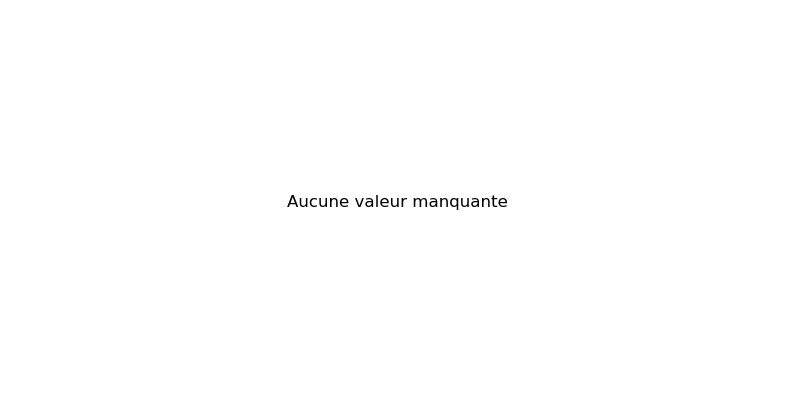

In [46]:
valeurs_manquantes_graph = valeurs_manquantes[valeurs_manquantes > 0].sort_values(ascending=False)

plt.figure(figsize=(10, 5))
# Prise en charge si valeurs manquetes à 0
if valeurs_manquantes_graph.empty:
    ax = plt.gca()
    ax.text(0.5, 0.5, "Aucune valeur manquante",
            ha="center", va="center", fontsize=12)
    ax.axis("off")
else:
    valeurs_manquantes_graph.plot(kind="bar")
    plt.title("Valeurs manquantes par colonne")
    plt.ylabel("Nombre de valeurs manquantes")
    plt.xticks(rotation=45, ha="right")

plt.show()

In [47]:
# Détection des noms de colonnes numériques ou catégorielles
numeric_features = df.select_dtypes(exclude="object").columns
categorical_features = df.select_dtypes(include="object").columns

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  Index(['id'], dtype='object')
Found categorical features  Index(['description'], dtype='object')


In [48]:
# Vérification valeurs numériques float uniques
numeric_float = df.select_dtypes('float64')

for col in numeric_float.columns:
  print(f"Colonne {col} : ", numeric_float[col].nunique())

In [49]:
# Vérification valeurs numériques int uniques
numeric_int = df.select_dtypes('int64')

for col in numeric_int.columns:
  print(f"Colonne {col} : ", numeric_int[col].nunique())

Colonne id :  500


In [50]:
# Vérification valeurs non numériques float uniques
non_numeric = df.select_dtypes('object')

for col in non_numeric.columns:
  print(f"Colonne {col} : ", non_numeric[col].nunique())

Colonne description :  500


# Cleaning

In [51]:
df["description"] = df["description"].astype(str)

In [52]:
# Sauvegarde du dataset nettoyé
df.to_csv("../data/outputs/sample-data-export-clean.csv", index=False)

# Analyse samantique

In [53]:
PATH = "../data/outputs/sample-data-export-clean.csv"

df = pd.read_csv(PATH, sep=',')

## Chargement du modèle linguistique

In [54]:
nlp = spacy.load("en_core_web_sm", disable=["parser","ner","textcat"])

# Construction corpus à partir de toutes les descriptions
corpus = " ".join(df["description"].astype(str).tolist())
text = re.sub(r"\s+", " ", corpus.lower())

## Nettoyage linguistique et tokenisation

In [55]:
text = re.sub(r"<.*?>", " ", text)

doc = nlp(text)
stop_en = set(nlp.Defaults.stop_words) | {"’", "“", "”", "–", "—", "br", "ul", "li", "b"}

tokens = [
    t.lemma_ for t in doc
    if t.pos_ in {"NOUN", "ADJ", "PROPN"}
    and len(t.lemma_) > 2
    and not t.is_punct and not t.like_num
    and t.lemma_ not in stop_en
]

freqs = Counter(tokens)

## Visualisation des mots fréquents

In [56]:
TOP_N = 25
df_top = pd.DataFrame(freqs.most_common(TOP_N), columns=["Lemmes","Fréquence"])
fig_bar = px.bar(
    df_top.sort_values("Fréquence"),
    x="Fréquence", y="Lemmes", orientation="h",
    color="Fréquence", color_continuous_scale="viridis",
    title=f"Top {TOP_N} lemmes les plus fréquents"
)
fig_bar.update_layout(yaxis={'categoryorder':'total ascending'})

fig_bar.show()